# Denoising Autoencoder

In [1]:
import logging

import sklearn
from fastai import learner
from fastai.basics import *
from fastai.callback.all import *
from fastai.torch_basics import *
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import pimmslearn
import pimmslearn.model
import pimmslearn.models as models
from pimmslearn.analyzers import analyzers
from pimmslearn.io import datasplits
# overwriting Recorder callback with custom plot_loss
from pimmslearn.models import ae, plot_loss

learner.Recorder.plot_loss = plot_loss


logger = pimmslearn.logging.setup_logger(logging.getLogger('pimmslearn'))
logger.info(
    "Experiment 03 - Analysis of latent spaces and performance comparisions")

figures = {}  # collection of ax or figures

pimmslearn - INFO     Experiment 03 - Analysis of latent spaces and performance comparisions


In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

Papermill script parameters:

In [3]:
# files and folders
# Datasplit folder with data for experiment
folder_experiment: str = 'runs/example'
folder_data: str = ''  # specify data directory if needed
file_format: str = 'csv'  # file format of create splits, default pickle (pkl)
# Machine parsed metadata from rawfile workflow
fn_rawfile_metadata: str = 'data/dev_datasets/HeLa_6070/files_selected_metadata_N50.csv'
# training
epochs_max: int = 50  # Maximum number of epochs
# early_stopping:bool = True # Wheather to use early stopping or not
patience: int = 25  # Patience for early stopping
batch_size: int = 64  # Batch size for training (and evaluation)
cuda: bool = True  # Whether to use a GPU for training
# model
# Dimensionality of encoding dimension (latent space of model)
latent_dim: int = 25
# A underscore separated string of layers, '128_64' for the encoder, reverse will be use for decoder
hidden_layers: str = '512'

sample_idx_position: int = 0  # position of index which is sample ID
model: str = 'DAE'  # model name
model_key: str = 'DAE'  # potentially alternative key for model (grid search)
save_pred_real_na: bool = True  # Save all predictions for missing values
# metadata -> defaults for metadata extracted from machine data
meta_date_col: str = None  # date column in meta data
meta_cat_col: str = None  # category column in meta data

In [4]:
# Parameters
model = "DAE"
latent_dim = 10
batch_size = 64
epochs_max = 300
hidden_layers = "64"
sample_idx_position = 0
cuda = False
save_pred_real_na = True
fn_rawfile_metadata = "https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv"
folder_experiment = "runs/alzheimer_study"
model_key = "DAE"


Some argument transformations

In [5]:
args = pimmslearn.nb.get_params(args, globals=globals())
args

{'folder_experiment': 'runs/alzheimer_study',
 'folder_data': '',
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'epochs_max': 300,
 'patience': 25,
 'batch_size': 64,
 'cuda': False,
 'latent_dim': 10,
 'hidden_layers': '64',
 'sample_idx_position': 0,
 'model': 'DAE',
 'model_key': 'DAE',
 'save_pred_real_na': True,
 'meta_date_col': None,
 'meta_cat_col': None}

In [6]:
args = pimmslearn.nb.args_from_dict(args)

if isinstance(args.hidden_layers, str):
    args.overwrite_entry("hidden_layers", [int(x)
                         for x in args.hidden_layers.split('_')])
else:
    raise ValueError(
        f"hidden_layers is of unknown type {type(args.hidden_layers)}")
args

{'batch_size': 64,
 'cuda': False,
 'data': Path('runs/alzheimer_study/data'),
 'epochs_max': 300,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'hidden_layers': [64],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'DAE',
 'model_key': 'DAE',
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'patience': 25,
 'sample_idx_position': 0,
 'save_pred_real_na': True}

Some naming conventions

In [7]:
TEMPLATE_MODEL_PARAMS = 'model_params_{}.json'

## Load data in long format

In [8]:
data = datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


data is loaded in long format

In [9]:
data.train_X.sample(5)

Sample ID   protein groups                     
Sample_075  G5E968                                15.901
Sample_114  Q8NES3;Q8NES3-3                       16.651
Sample_089  O60565                                13.385
Sample_051  P04264                                20.160
Sample_002  A0A0A0MTC8;Q9NQ36;Q9NQ36-2;Q9NQ36-3   14.346
Name: intensity, dtype: float64

Infer index names from long format

In [10]:
index_columns = list(data.train_X.index.names)
sample_id = index_columns.pop(args.sample_idx_position)
if len(index_columns) == 1:
    index_column = index_columns.pop()
    index_columns = None
    logger.info(f"{sample_id = }, single feature: {index_column = }")
else:
    logger.info(f"{sample_id = }, multiple features: {index_columns = }")

if not index_columns:
    index_columns = [sample_id, index_column]
else:
    raise NotImplementedError(
        "More than one feature: Needs to be implemented. see above logging output.")

pimmslearn - INFO     sample_id = 'Sample ID', single feature: index_column = 'protein groups'


load meta data for splits

In [11]:
if args.fn_rawfile_metadata:
    df_meta = pd.read_csv(args.fn_rawfile_metadata, index_col=0)
    display(df_meta.loc[data.train_X.index.levels[0]])
else:
    df_meta = None

,_collection site,_age at CSF collection,_gender,_t-tau [ng/L],_p-tau [ng/L],_Abeta-42 [ng/L],_Abeta-40 [ng/L],_Abeta-42/Abeta-40 ratio,_primary biochemical AD classification,_clinical AD diagnosis,_MMSE score
Sample ID,,,,,,,,,,,
Sample_000,Sweden,71.000,f,703.000,85.000,562.000,NaN,NaN,biochemical control,NaN,NaN
Sample_001,Sweden,77.000,m,518.000,91.000,334.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_002,Sweden,75.000,m,974.000,87.000,515.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_003,Sweden,72.000,f,950.000,109.000,394.000,NaN,NaN,biochemical AD,NaN,NaN
Sample_004,Sweden,63.000,f,873.000,88.000,234.000,NaN,NaN,biochemical AD,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,Berlin,69.000,f,"1,945.000",NaN,699.000,"12,140.000",0.058,biochemical AD,AD,17.000
Sample_206,Berlin,73.000,m,299.000,NaN,"1,420.000","16,571.000",0.086,biochemical control,non-AD,28.000
Sample_207,Berlin,71.000,f,262.000,NaN,639.000,"9,663.000",0.066,biochemical control,non-AD,28.000


### Produce some addional simulated samples

The validation simulated NA is used to by all models to evaluate training performance.

In [12]:
val_pred_simulated_na = data.val_y.to_frame(name='observed')
val_pred_simulated_na

,,observed
Sample ID,protein groups,
Sample_158,Q9UN70;Q9UN70-2,14.630
Sample_050,Q9Y287,15.755
Sample_107,Q8N475;Q8N475-2,15.029
Sample_199,P06307,19.376
Sample_067,Q5VUB5,15.309
...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822
Sample_002,A0A0A0MT36,18.165
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525


In [13]:
test_pred_simulated_na = data.test_y.to_frame(name='observed')
test_pred_simulated_na.describe()

,observed
count,"12,600.000"
mean,16.339
std,2.741
min,7.209
25%,14.412
50%,15.935
75%,17.910
max,30.140


## Data in wide format

- Autoencoder need data in wide format

In [14]:
data.to_wide_format()
args.M = data.train_X.shape[-1]
data.train_X.head()

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN


### Fill Validation data with potentially missing features

In [15]:
data.train_X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,NaN,15.050,16.842,NaN,NaN,19.563,NaN,12.805
Sample_001,NaN,16.874,15.519,16.387,NaN,19.941,18.786,17.144,NaN,19.067,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,NaN,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,NaN,12.445
Sample_004,15.603,15.331,15.375,16.679,NaN,20.450,18.682,17.081,14.140,19.686,...,14.757,NaN,NaN,15.256,17.075,19.582,15.328,NaN,13.145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,NaN,17.705,17.039,NaN,16.413,19.102,...,NaN,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,NaN
Sample_206,15.798,17.554,15.600,15.938,NaN,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,NaN,15.345,17.084,18.708,NaN,19.433,NaN,NaN
Sample_207,15.739,NaN,15.469,16.898,NaN,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,NaN,18.725,16.138,19.599,13.637,11.174


In [16]:
data.val_y  # potentially has less features

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.863,NaN,NaN,NaN,NaN
Sample_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_002,NaN,14.523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_004,NaN,NaN,NaN,NaN,15.473,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.048,NaN,NaN,NaN,NaN,19.867,NaN,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.802
Sample_206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data.val_y = pd.DataFrame(pd.NA, index=data.train_X.index,
                          columns=data.train_X.columns).fillna(data.val_y)
data.val_y

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.863,NaN,NaN,NaN,NaN
Sample_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_002,NaN,14.523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_004,NaN,NaN,NaN,NaN,15.473,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.048,NaN,NaN,NaN,NaN,19.867,NaN,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.802
Sample_206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Denoising Autoencoder

### Analysis: DataLoaders, Model, transform

In [18]:
default_pipeline = sklearn.pipeline.Pipeline(
    [
        ('normalize', StandardScaler()),
        ('impute', SimpleImputer(add_indicator=False))
    ])

analysis = ae.AutoEncoderAnalysis(
    train_df=data.train_X,
    val_df=data.val_y,
    model=ae.Autoencoder,
    transform=default_pipeline,
    decode=['normalize'],
    model_kwargs=dict(n_features=data.train_X.shape[-1],
                      n_neurons=args.hidden_layers,
                      last_decoder_activation=None,
                      dim_latent=args.latent_dim),
    bs=args.batch_size)
args.n_params = analysis.n_params_ae

if args.cuda:
    analysis.model = analysis.model.cuda()
analysis.model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1421, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=64, out_features=1421, bias=True)
  )
)

### Training

In [19]:
analysis.learn = Learner(dls=analysis.dls,
                         model=analysis.model,
                         loss_func=MSELossFlat(reduction='sum'),
                         cbs=[EarlyStoppingCallback(patience=args.patience),
                              ae.ModelAdapter(p=0.2)]
                         )

analysis.learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, EarlyStoppingCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter, CastToTensor]
         - after_pred     : [ModelAdapter]
         - after_loss     : [ModelAdapter]
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - a

Adding a `EarlyStoppingCallback` results in an error.  Potential fix in
[PR3509](https://github.com/fastai/fastai/pull/3509) is not yet in
current version. Try again later

In [20]:
# learn.summary()

SuggestedLRs(valley=0.019054606556892395)

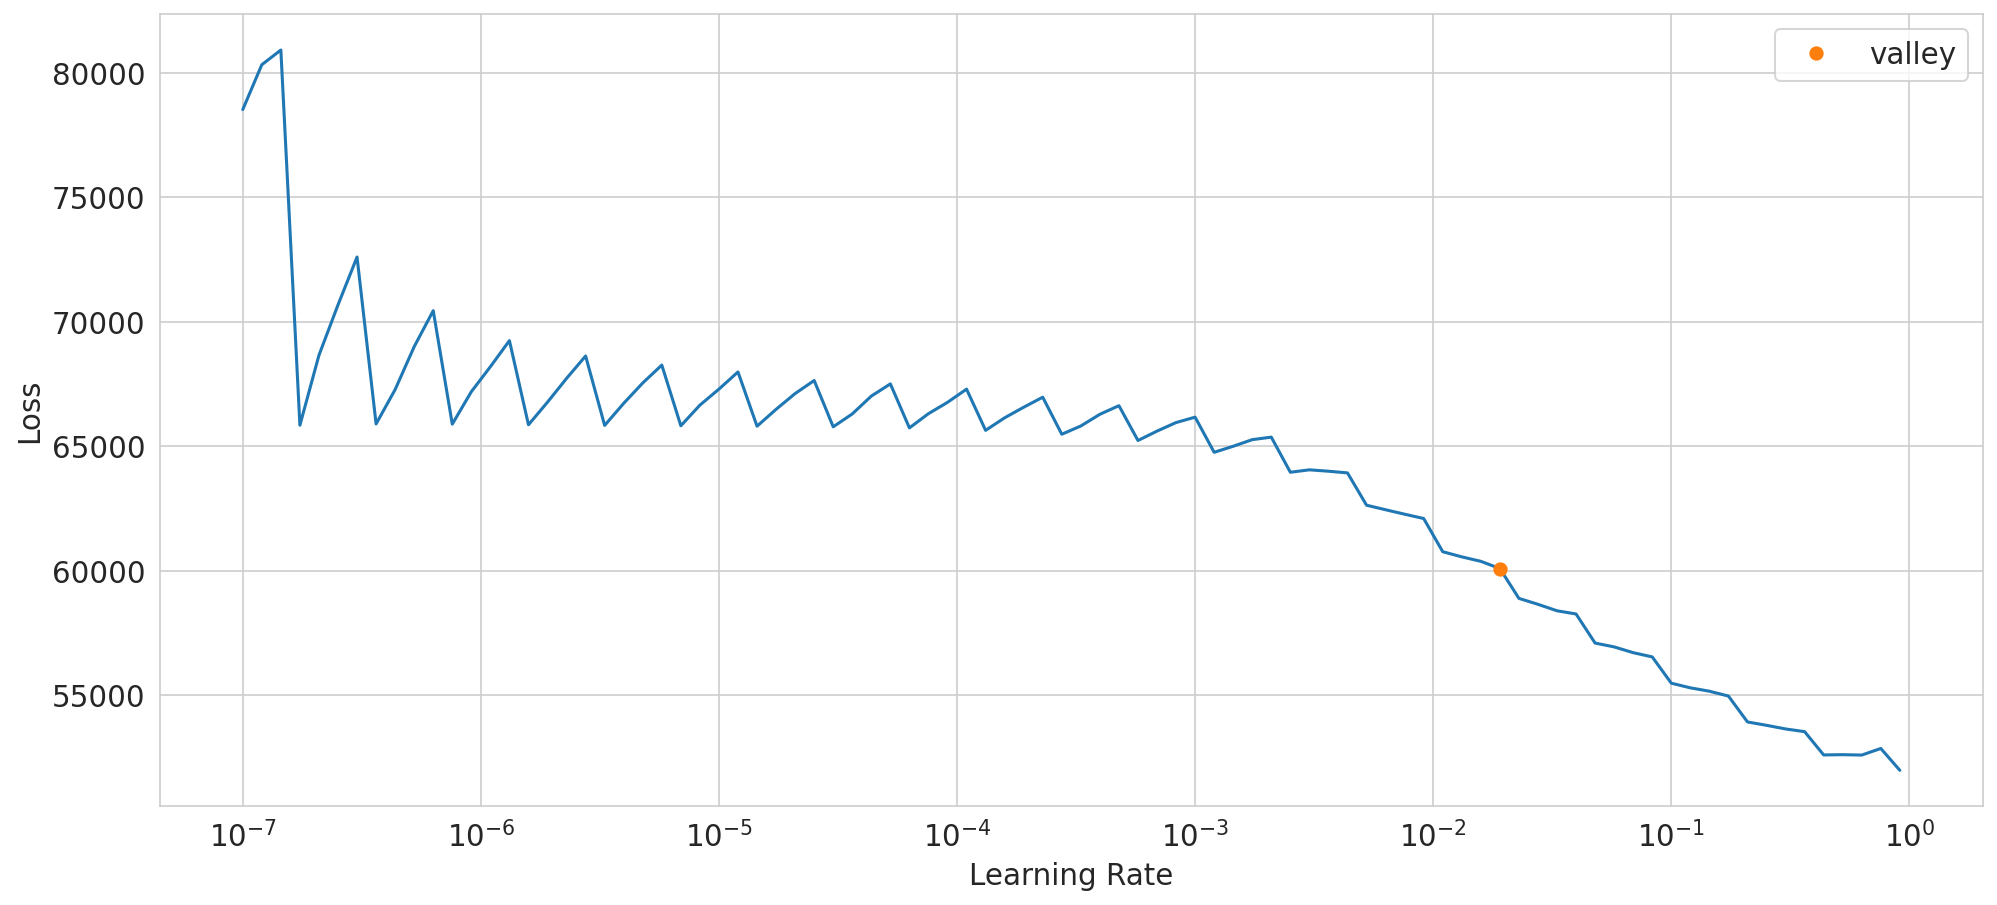

In [21]:
suggested_lr = analysis.learn.lr_find()
analysis.params['suggested_inital_lr'] = suggested_lr.valley
suggested_lr

dump model config

In [22]:
pimmslearn.io.dump_json(analysis.params, args.out_models /
                        TEMPLATE_MODEL_PARAMS.format(args.model_key))

In [23]:
# papermill_description=train
analysis.learn.fit_one_cycle(args.epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,64764.441406,4026.617920,00:00
1,63048.136719,3992.490723,00:00
2,61626.257812,3926.113281,00:00
3,60294.230469,3832.158691,00:00
4,58974.359375,3714.533691,00:00
5,57635.214844,3577.657227,00:00
6,56311.507812,3443.319092,00:00
7,55027.417969,3320.914062,00:00
8,53760.343750,3222.342529,00:00
9,52505.109375,3136.820557,00:00


No improvement since epoch 152: early stopping


Save number of actually trained epochs

In [24]:
args.epoch_trained = analysis.learn.epoch + 1
args.epoch_trained

178

#### Loss normalized by total number of measurements

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/figures/dae_training


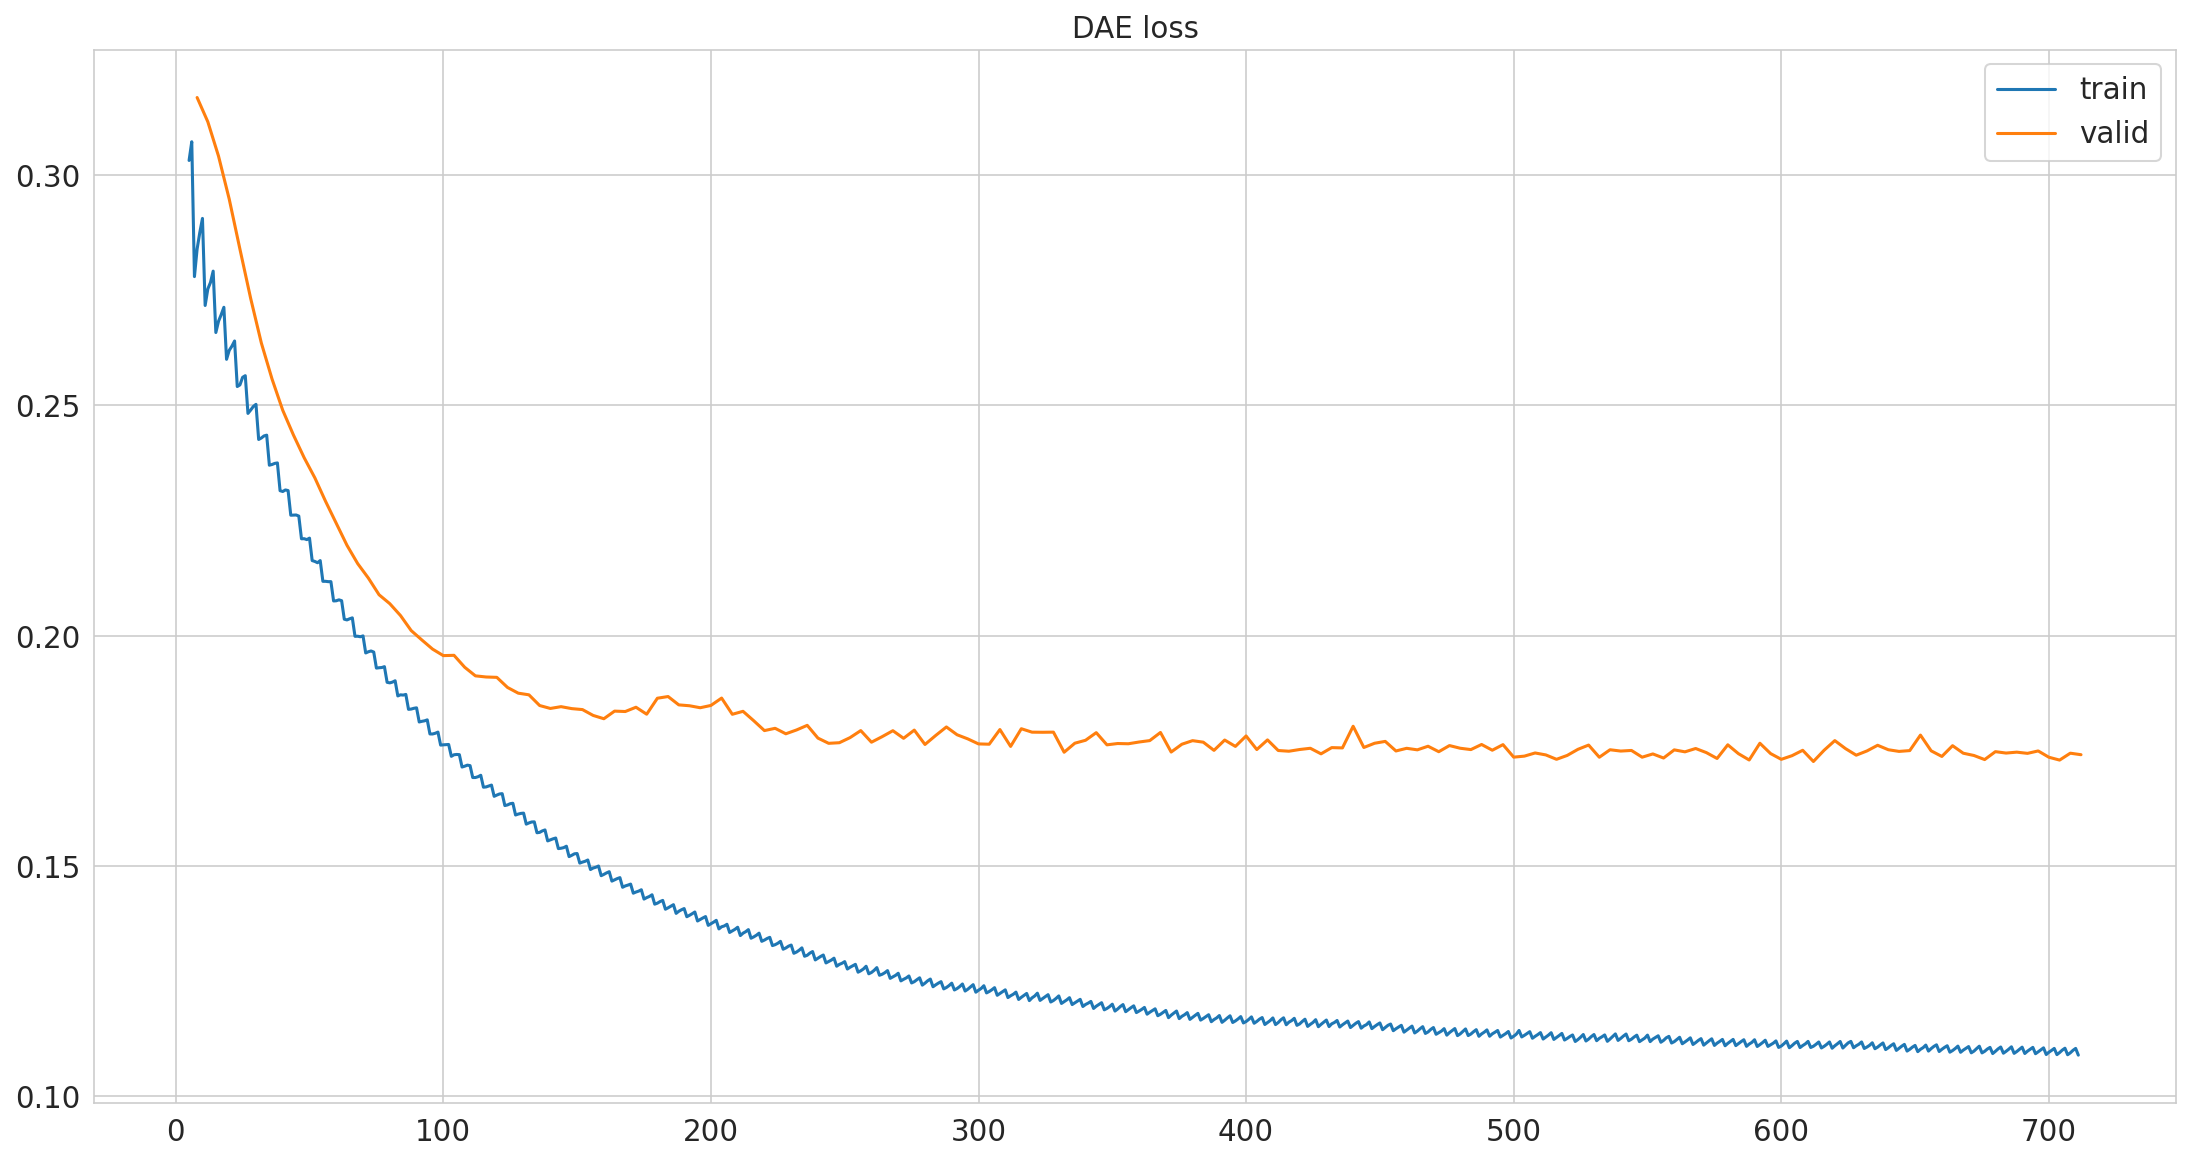

In [25]:
N_train_notna = data.train_X.notna().sum().sum()
N_val_notna = data.val_y.notna().sum().sum()
fig = models.plot_training_losses(analysis.learn, args.model_key,
                                  folder=args.out_figures,
                                  norm_factors=[N_train_notna, N_val_notna])

Why is the validation loss better then the training loss?
- during training input data is masked and needs to be reconstructed
- when evaluating the model, all input data is provided and only the artifically masked data is used for evaluation.

### Predictions

- data of training data set and validation dataset to create predictions is the same as training data.
- predictions include missing values (which are not further compared)

- [ ] double check ModelAdapter

create predictiona and select for validation data

In [26]:
analysis.model.eval()
pred, target = analysis.get_preds_from_df(df_wide=data.train_X)  # train_X
pred = pred.stack()
pred

Sample ID   protein groups                                                                
Sample_000  A0A024QZX5;A0A087X1N8;P35237                                                     16.010
            A0A024R0T9;K7ER74;P02655                                                         16.784
            A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8   15.813
            A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503                                          16.700
            A0A075B6H7                                                                       17.059
                                                                                              ...  
Sample_209  Q9Y6R7                                                                           19.141
            Q9Y6X5                                                                           15.738
            Q9Y6Y8;Q9Y6Y8-2                                                                  19.469
         

In [27]:
val_pred_simulated_na['DAE'] = pred  # model_key ?
val_pred_simulated_na

,,observed,DAE
Sample ID,protein groups,,
Sample_158,Q9UN70;Q9UN70-2,14.630,15.932
Sample_050,Q9Y287,15.755,16.960
Sample_107,Q8N475;Q8N475-2,15.029,14.419
Sample_199,P06307,19.376,19.025
Sample_067,Q5VUB5,15.309,15.294
...,...,...,...
Sample_111,F6SYF8;Q9UBP4,22.822,22.916
Sample_002,A0A0A0MT36,18.165,16.044
Sample_049,Q8WY21;Q8WY21-2;Q8WY21-3;Q8WY21-4,15.525,15.669


In [28]:
test_pred_simulated_na['DAE'] = pred  # model_key?
test_pred_simulated_na

observed  \
Sample ID  protein groups                                                        
Sample_000 A0A075B6P5;P01615                                            17.016   
           A0A087X089;Q16627;Q16627-2                                   18.280   
           A0A0B4J2B5;S4R460                                            21.735   
           A0A140T971;O95865;Q5SRR8;Q5SSV3                              14.603   
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4    16.143   
...                                                                        ...   
Sample_209 Q96ID5                                                       16.074   
           Q9H492;Q9H492-2                                              13.173   
           Q9HC57                                                       14.207   
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                     14.962   
           Q9UGM5;Q9UGM5-2                                              16.871   

                                                                        DAE  
Sample ID  protein groups                                                    
Sample_000 A0A075B6P5;P01615                                         17.068  
           A0A087X089;Q16627;Q16627-2                                18.181  
           A0A0B4J2B5;S4R460                                         22.329  
           A0A140T971;O95865;Q5SRR8;Q5SSV3                           15.119  
           A0A140TA33;A0A140TA41;A0A140TA52;P22105;P22105-3;P22105-4 16.525  
...                                                                     ...  
Sample_209 Q96ID5                                                    15.814  
           Q9H492;Q9H492-2                                           13.345  
           Q9HC57                                                    13.558  
           Q9NPH3;Q9NPH3-2;Q9NPH3-5                                  15.237  
           Q9UGM5;Q9UGM5-2                                           16.368  

[12600 rows x 2 columns]

save missing values predictions

In [29]:
if args.save_pred_real_na:
    pred_real_na = ae.get_missing_values(df_train_wide=data.train_X,
                                         val_idx=val_pred_simulated_na.index,
                                         test_idx=test_pred_simulated_na.index,
                                         pred=pred)
    display(pred_real_na)
    pred_real_na.to_csv(args.out_preds / f"pred_real_na_{args.model_key}.csv")

Sample ID   protein groups          
Sample_000  A0A075B6J9                 15.483
            A0A075B6Q5                 16.182
            A0A075B6R2                 16.587
            A0A075B6S5                 16.190
            A0A087WSY4                 16.987
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   16.053
            Q9UI40;Q9UI40-2            16.103
            Q9UIW2                     17.238
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   14.008
            Q9UP79                     15.949
Name: intensity, Length: 46401, dtype: float32

### Plots

- validation data

In [30]:
analysis.model.cpu()
df_latent = pimmslearn.model.get_latent_space(analysis.model.encoder,
                                              dl=analysis.dls.valid,
                                              dl_index=analysis.dls.valid.data.index)
df_latent

,latent dimension 1,latent dimension 2,latent dimension 3,latent dimension 4,latent dimension 5,latent dimension 6,latent dimension 7,latent dimension 8,latent dimension 9,latent dimension 10
Sample ID,,,,,,,,,,
Sample_000,0.037,0.653,1.566,2.480,4.975,-0.225,1.953,0.609,3.701,-0.777
Sample_001,-0.726,-0.841,2.857,1.990,4.829,-2.482,-0.283,-0.633,2.305,-2.270
Sample_002,-5.044,1.692,-0.486,0.097,4.525,0.465,-1.003,-2.583,3.565,-2.132
Sample_003,0.094,1.087,-0.009,1.869,3.863,-1.236,0.318,0.368,4.301,0.249
Sample_004,0.519,-0.169,-0.373,2.444,5.702,-2.716,2.453,-2.720,3.305,-0.298
...,...,...,...,...,...,...,...,...,...,...
Sample_205,1.426,1.019,-3.002,-0.727,3.087,3.484,-0.505,-2.181,1.383,-4.346
Sample_206,0.398,-2.056,0.061,-1.059,6.789,5.535,0.198,1.861,-3.506,-0.403
Sample_207,1.237,-1.210,-1.444,1.383,1.809,2.839,4.240,-0.917,-2.244,-4.192


In [31]:
# ! calculate embeddings only if meta data is available? Optional argument to save embeddings?
ana_latent = analyzers.LatentAnalysis(df_latent,
                                      df_meta,
                                      args.model_key,
                                      folder=args.out_figures)
if args.meta_date_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_date'], ax = ana_latent.plot_by_date(
        args.meta_date_col)

In [32]:
if args.meta_cat_col and df_meta is not None:
    figures[f'latent_{args.model_key}_by_{"_".join(args.meta_cat_col.split())}'], ax = ana_latent.plot_by_category(
        args.meta_cat_col)

## Comparisons

Simulated NAs : Artificially created NAs. Some data was sampled and set
explicitly to misssing before it was fed to the model for
reconstruction.

### Validation data

- all measured (identified, observed) peptides in validation data

In [33]:
# papermill_description=metrics
d_metrics = models.Metrics()

The simulated NA for the validation step are real test data (not used for training nor early stopping)

In [34]:
added_metrics = d_metrics.add_metrics(val_pred_simulated_na, 'valid_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'DAE': {'MSE': 0.4651546112127017,
  'MAE': 0.4342005403889394,
  'N': 12600,
  'prop': 1.0}}

### Test Datasplit

In [35]:
added_metrics = d_metrics.add_metrics(test_pred_simulated_na, 'test_simulated_na')
added_metrics

Selected as truth to compare to: observed


{'DAE': {'MSE': 0.47557279801999236,
  'MAE': 0.43561720898059586,
  'N': 12600,
  'prop': 1.0}}

Save all metrics as json

In [36]:
pimmslearn.io.dump_json(d_metrics.metrics, args.out_metrics /
                        f'metrics_{args.model_key}.json')
d_metrics

{ 'test_simulated_na': { 'DAE': { 'MAE': 0.43561720898059586,
                                  'MSE': 0.47557279801999236,
                                  'N': 12600,
                                  'prop': 1.0}},
  'valid_simulated_na': { 'DAE': { 'MAE': 0.4342005403889394,
                                   'MSE': 0.4651546112127017,
                                   'N': 12600,
                                   'prop': 1.0}}}

In [37]:
metrics_df = models.get_df_from_nested_dict(d_metrics.metrics,
                                            column_levels=['model', 'metric_name']).T
metrics_df

subset             valid_simulated_na  test_simulated_na
model metric_name                                       
DAE   MSE                       0.465              0.476
      MAE                       0.434              0.436
      N                    12,600.000         12,600.000
      prop                      1.000              1.000

## Save predictions

In [38]:
# save simulated missing values for both splits
val_pred_simulated_na.to_csv(args.out_preds / f"pred_val_{args.model_key}.csv")
test_pred_simulated_na.to_csv(args.out_preds / f"pred_test_{args.model_key}.csv")

## Config

In [39]:
figures  # switch to fnames?

{}

In [40]:
args.dump(fname=args.out_models / f"model_config_{args.model_key}.yaml")
args

{'M': 1421,
 'batch_size': 64,
 'cuda': False,
 'data': Path('runs/alzheimer_study/data'),
 'epoch_trained': 178,
 'epochs_max': 300,
 'file_format': 'csv',
 'fn_rawfile_metadata': 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/meta.csv',
 'folder_data': '',
 'folder_experiment': Path('runs/alzheimer_study'),
 'hidden_layers': [64],
 'latent_dim': 10,
 'meta_cat_col': None,
 'meta_date_col': None,
 'model': 'DAE',
 'model_key': 'DAE',
 'n_params': 184983,
 'out_figures': Path('runs/alzheimer_study/figures'),
 'out_folder': Path('runs/alzheimer_study'),
 'out_metrics': Path('runs/alzheimer_study'),
 'out_models': Path('runs/alzheimer_study'),
 'out_preds': Path('runs/alzheimer_study/preds'),
 'patience': 25,
 'sample_idx_position': 0,
 'save_pred_real_na': True}